# Lab-3:
# Exercise 1:

> Importing necessary libraries:

In [127]:
import pandas as pd
import numpy as np
from numpy import mean,std
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler,OrdinalEncoder
from sklearn.model_selection import RepeatedKFold,train_test_split,cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, roc_curve
sb.set_theme()

> Loading the dataset:

In [128]:
titanic = pd.read_csv('titanic/train.csv')
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


> <b>Metadata:</b></br>
> |Variable|Definition|Key|
> |--------|----------|---|
> |survival|Survival|0 = No, 1 = Yes|
> pclass|Ticket class|1 = 1st, 2 = 2nd, 3 = 3rd|
> |sex|Sex||	
> |Age|Age in years||	
> |sibsp|# of siblings / spouses aboard the Titanic||	
> |parch|# of parents / children aboard the Titanic||	
> |ticket|Ticket number||	
> |fare|Passenger fare||	
> |cabin|Cabin number||	
> |embarked|Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton||
>
> <b>Variable Notes:</b></br>
>pclass: A proxy for socio-economic status (SES)</br>
> 1st = Upper</br>
> 2nd = Middle</br>
> 3rd = Lower</br>
>
> age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5</br>
> 
> sibsp: The dataset defines family relations in this way...</br>
> Sibling = brother, sister, stepbrother, stepsister</br>
> Spouse = husband, wife (mistresses and fiancés were ignored)</br>
> 
> parch: The dataset defines family relations in this way...</br>
> Parent = mother, father</br>
> Child = daughter, son, stepdaughter, stepson</br>
> Some children travelled only with a nanny, therefore parch=0 for them.

#### Question-1: Use the titanic data set, perform preprocessing by deal with missing values, drop irrelevant attributes.

> Finding the number of missing data:

In [129]:
titanic.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

From above we can observe that data for the attributes, Age, Cabin and Embarked are not present for some entries.

In [130]:
titanic.corr(method='pearson')

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


> Dropping columns with less correlation with respect to the "Survived" attribute:

In [131]:
titanic_preprocessed = titanic.drop(columns=['Name','PassengerId','Fare','Ticket','Cabin'])


> Analyzing the data to replace the missing values:

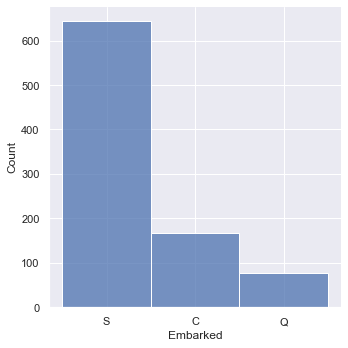

In [132]:
sb.displot(titanic_preprocessed['Embarked'])

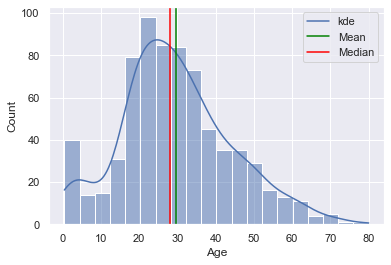

In [133]:
sb.histplot(data=titanic_preprocessed.Age, kde=True)
plt.axvline(titanic_preprocessed.Age.mean(), color='Green')
plt.axvline(titanic_preprocessed.Age.median(), color='Red')
plt.legend(['kde','Mean','Median'])

Hence we will replace the values for "Embarked" with the mode of the data and median in case of "Age"

> Replacing missing "Embarked" values with the mode of the data and "Age" with the Median:

In [134]:
titanic_preprocessed['Embarked'] = titanic_preprocessed['Embarked'].fillna(titanic_preprocessed.Embarked.mode()[0])
titanic_preprocessed['Age'] = titanic_preprocessed['Age'].fillna(titanic_preprocessed.Age.median())

In [135]:
titanic_preprocessed.isna().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Embarked    0
dtype: int64

#### Question-2: Use the scikit learn pipelines  to perform the preprocessing -  standardizing, encoding and  model fitting in one step. 

In [136]:
titanic_preprocessed.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Embarked
0,0,3,male,22.0,1,0,S
1,1,1,female,38.0,1,0,C
2,1,3,female,26.0,0,0,S
3,1,1,female,35.0,1,0,S
4,0,3,male,35.0,0,0,S


In [137]:
ord_enc = OrdinalEncoder()
titanic_preprocessed['Sex'] = ord_enc.fit_transform(titanic_preprocessed[['Sex']])
titanic_preprocessed['Embarked'] = ord_enc.fit_transform(titanic_preprocessed[['Embarked']])
x = titanic_preprocessed.drop(['Survived'], axis=1)
y = titanic_preprocessed.Survived
x_train, x_test, y_train, y_test = train_test_split(x,y,train_size=0.7, random_state=42)
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('encoder',OrdinalEncoder()),
    ('model', GaussianNB())
])
pipe.fit(x_train,y_train)
y_pred = pipe.predict(x_train)
proba = pipe.predict_proba(x_train)
pipe.score(x_train,y_train)

0.7913322632423756

#### Question-3: Perform Bayes classification using cross validation.

In [138]:
cv = RepeatedKFold(n_splits=10,n_repeats=3)
model = GaussianNB()
scores = cross_val_score(model, x, y, scoring='accuracy', cv=5, n_jobs=-1)
scores.mean()

0.7800703031824744

#### Question-4: Tabulate using relevant measures of accuracy , Sensitivity and specificity.

In [139]:
print(classification_report(y_train,y_pred))

              precision    recall  f1-score   support

           0       0.83      0.83      0.83       392
           1       0.72      0.72      0.72       231

    accuracy                           0.79       623
   macro avg       0.78      0.78      0.78       623
weighted avg       0.79      0.79      0.79       623



#### Question-5: Visualize the ROC curve and comment on performance.

Text(0, 0.5, 'True Positive Rate')

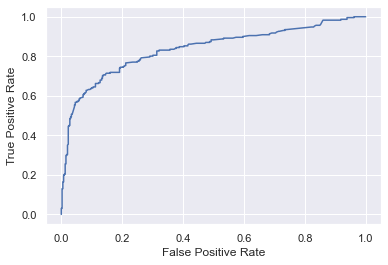

In [140]:
fpr, tpr, thres = roc_curve(y_train,proba[:,1])
plt.plot(fpr,tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")